In [1]:
%matplotlib inline

In [2]:
import matplotlib as mpl
#mpl.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import h5py, pylab, struct
import matplotlib.cm as cm
import conversions as co
import pandas as pd

#### TODO:
* PLOTS

#### Aspirations:
* Wrap the hdf5 reader such that it can read in chunks at a time

#### Notes:
* snap hdf5 structure: f has keys 'Header', 'PartType1,2,3'
* PartTypes have no attrs, keys = "Coordinates", "ParticleIDs", "Velocities" with no attrs
    * Coords and Vels are ndarrays len == 3
    * PT1=DM (20mil x 3), PT2=disk (8mil x 3), PT3=bulge (2.8mil x 3)
* header has attributes with value == 0: 
    * BoxSize, OmegaLambda, Redshift
    * Flag_[Cooling, DoublePrecision, Feedback, IC_Info, Metals, Sfr, StellarAge]
* nonzero attrs: 
    * HubbleParam, Omega0 == 1, Time (in years / 10^9 (????))
    * NumPart_ThisFile == NumPart_Total (array len 6), MassTable (array len 6)

In [3]:
def read_hdf5(path, p_type=1):
    """types: 1=DM, 2=disk, 3=bulge"""
    groups = ["Header", "PartType1", "PartType2", "PartType3"]
    head = {}
    
    f = h5py.File(path, "r")
    h = f["Header"]
    keys = list(h.attrs)
    for key in keys:
        head[key] = h.attrs[key]
    parts = f[groups[p_type]]
    columns = ["x","y","z", "vx", "vy", "vz"]
    df = pd.DataFrame(np.concatenate((parts["Coordinates"], parts["Velocities"]), axis=1),
                     columns=columns, index=parts["ParticleIDs"][:])
    f.close()
    
    return head, df
def df_center(df):
    idxs = ['x', 'y', 'z']
    for idx in idxs:
        df[idx] -= df[idx].median()
def df_polar(df):
    df['r'] = np.sqrt(df['x'] ** 2 + df['y'] ** 2)
    df['theta'] = np.arctan2(df['x'], df['y'])
def hist2d(df, xcol, ycol, bins=None, rng=None):
    if bins==None:
        pass
    h, xedg, yedg, mesh = plt.hist2d(df[xcol], df[ycol],)
    pass

In [4]:
path = "data/snap_582.hdf5"
head, df = read_hdf5(path, p_type=1) #testing with fewer particles
df_center(df)
df_polar(df)
df['z'].describe()
#hist ,xbin, ybin = np.histogram2d(df["x"], df["y"], normed=True, bins=[360,360])
#plt.hist2d(df["x"], df["y"], density=True, bins=[360,360])

count    2.000000e+07
mean    -9.819767e-01
std      3.728901e+02
min     -8.129112e+03
25%     -2.652592e+01
50%      1.192093e-07
75%      2.567650e+01
max      8.099432e+03
Name: z, dtype: float64

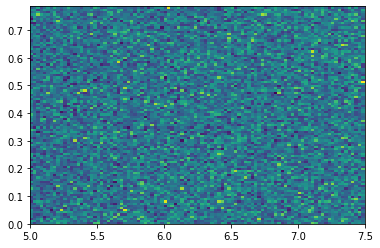

In [5]:
h, redg, thedg, img = plt.hist2d(df["r"][df['z'].abs() > 1], df["theta"][df['z'].abs() > 1],
                                 bins=[100,100], range=[[5, 7.5],[0,np.pi/4]], density=True)
# NEXT TODO: use (z cutoff) & (theta cutoff) & (r cutoff), then plot x&y

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


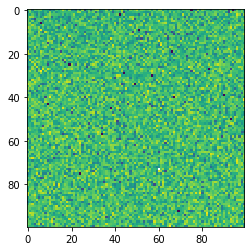

In [6]:
plt.imshow(np.log10(h))

In [234]:
head["HubbleParam"]

0.678

Rs =  1.8726196215911357 2.8770973183672403e-07


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10


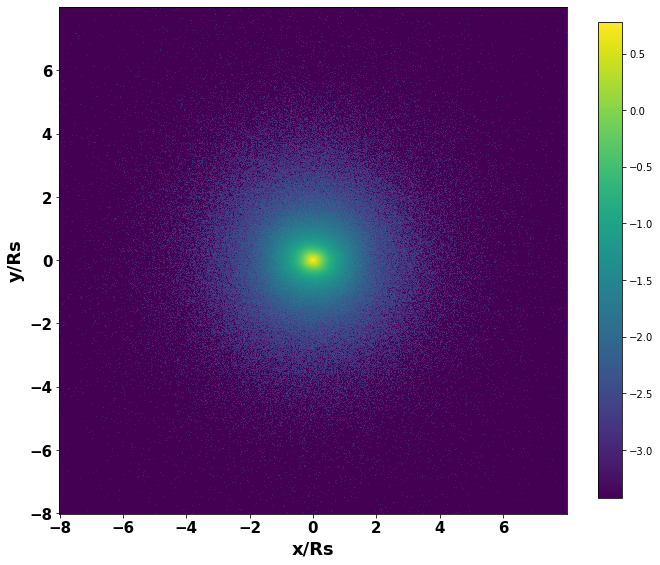

In [189]:
path = "data/snap_582.hdf5"
head, df = read_hdf5(path, p_type=3) #testing with fewer particles
df["x"] = df["x"] - df["x"].median()
df["y"] = df["y"] - df["y"].median()
mass = head["MassTable"][3]
BINS_r, BINS_theta = 360,360
BINS=512
lengthX=15.0
lengthY=15.0
vx0=-5.0
vy0=170.0
Zmin=-4.25
Zmax=-0.27
rmin, rmax = 0., 15.
dtheta=2*np.pi/BINS_theta
dr=(rmax-rmin)/BINS_r
thetamid=(np.arange(BINS_theta)+0.5) * dtheta - np.pi   
rmid=(np.arange(BINS_r)+0.5) * dr + rmin

px,py = df["x"], df["y"]
r=np.sqrt(px**2. + py**2.) 
theta=np.arctan2(py,px)
h, x, y = np.histogram2d(r,theta,bins=[BINS_r,BINS_theta],range=[[rmin,rmax],[-np.pi,np.pi]])

#divide by area to get surface density
for i in range(0,BINS_r):
        h[i,:]/=rmid[i]*dr*dtheta

#fit the axisymmetric surface density            
meanh=np.zeros(BINS_r)
for i in range(0,BINS_r):
        meanh[i]=h[i,:].mean()
z=np.polyfit(rmid, np.log(meanh), 1)
Rs=-1/z[0]
p = np.poly1d(z)
print( "Rs = ", Rs, mass )

#calculate residuals
for i in range(0,BINS_r):
        #h[i,:]=(h[i,:] - np.exp(p(rmid[i]))) / np.exp(p(rmid[i]))
        h[i,:]=(h[i,:] - h[i,:].mean()) / (h[i,:].mean())
Z,x,y=np.histogram2d(px/Rs,py/Rs, range=[[-lengthX/Rs,lengthX/Rs],[-lengthY/Rs,lengthY/Rs]], bins=BINS, normed=True)

Z=np.log10(Z)


Zmin=Z[Z>-np.inf].min()
Zmax=Z[Z<np.inf].max()
if ((Zmax==0.0) & (Zmin==0.0)):
        Zmin=Z[Z>-np.inf].min()
        Zmax=Z.max()
else:
        Z[Z<Zmin]=Zmin
        Z[Z>Zmax]=Zmax
fig = plt.figure(1, figsize=(25.0,25.0))

#left plot
#ax = fig.add_subplot(1,2,1,title=tname+"  t="+str(round(head.time*co.UnitTime_in_Gyr*1000.0,1))+"Myr")

ax = fig.add_subplot(1,2,1) #,title=tname+"  t="+str(round(myTime*co.UnitTime_in_Gyr*1000.0,1))+"Myr")
im=ax.imshow(Z.T, vmin=Zmin, vmax=Zmax,
        origin='lower',interpolation='nearest',
        extent=[-lengthX/Rs,lengthX/Rs,-lengthY/Rs,lengthY/Rs],
        cmap=cm.get_cmap('viridis'))
ax.set_xlabel('x/Rs', fontsize=18, fontweight='bold')
ax.set_ylabel('y/Rs',fontsize=18, fontweight='bold')
plt.xticks(np.arange(-round(lengthX/Rs), round(lengthX/Rs), step=2), fontsize=15, fontweight='bold')
plt.yticks(np.arange(-round(lengthY/Rs), round(lengthY/Rs), step=2), fontsize=15, fontweight='bold')
plt.colorbar(im, shrink=0.35)        

19.794922
done


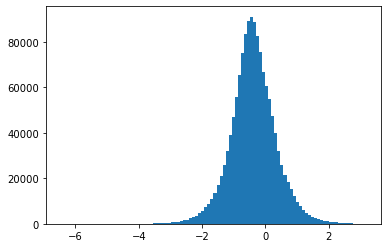

In [226]:
bins = 100
#hist, xedg, yedg, img = plt.hist2d(df["x"], df["y"], density=True, bins=[bins,bins], cmin=1)
x,y = df["x"], df["y"]
std = x.std()
high = std
low = -std
#plt.hist2d(df["x"], df["y"])
plt.hist(np.log10(x), bins=bins)

In [ ]:
img